# 1 Build a dataloader

In [1]:
import torch
import seaborn as sns
import sys
from pathlib import Path
sys.path.insert(0, "../..")

In [2]:
from src.data import make_dataset
#from src.models import imagemodels
#from src.models import train_model
import gin


2022-06-04 10:02:59.404220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 10:02:59.404249: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'Path' is not defined

Get EEG data

In [13]:
data = make_dataset.get_eeg()

2022-06-04 09:57:02.725 | INFO     | src.data.make_dataset:get_eeg:31 - Data is downloaded to /tmp/.keras/datasets/eeg.


See one row

In [10]:
len(data)

TypeError: object of type 'PosixPath' has no len()

The `iter_valid_paths` function pulls all files, strips the corrects suffixes (we only want images), retrieves the classnames by gathering the names of the subfolders, and returns both

In [7]:
def iter_valid_paths(
    path: Path, formats: List[str]
) -> Tuple[Iterator, List[str]]:
    # gets all files in folder and subfolders
    walk = walk_dir(path)
    # retrieves foldernames as classnames
    class_names = [subdir.name for subdir in path.iterdir() if subdir.is_dir()]
    # keeps only specified formats
    paths = (path for path in walk if path.suffix in formats)
    return paths, class_names

In [8]:
formats = [".png", ".jpg"]
paths, class_names = iter_valid_paths(
    path = image_folder, 
    formats=formats
)

In [9]:
next(paths), class_names

(PosixPath('/Users/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/roses/16209331331_343c899d38.jpg'),
 ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'])

And, last, we need the `load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [10]:
def load_image(
    path: Path, image_size: Tuple[int, int], channels: int
) -> np.ndarray:
    # load file
    img_ = tf.io.read_file(str(path))
    # decode as image
    img = tf.image.decode_image(img_, channels=channels)
    # resize with bilinear algorithm
    img_resize = tf.image.resize(img, image_size, method="bilinear")
    # add correct shape with channels-last convention
    img_resize.set_shape((image_size[0], image_size[1], channels))
    # cast to numpy
    return img_resize.numpy()

In [11]:
%timeit load_image(file, image_size=(180, 180), channels=3)

2.67 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
file = next(paths)
img = load_image(file, (180, 180), 3)
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

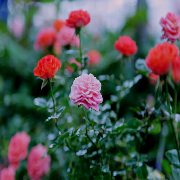

In [13]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

I implemented everything in the `src/data/data_tools.py` file, in a `Dataloader` class. Check out the file and study how I did that.

In [14]:
dataloader = data_tools.Dataloader(path=image_folder, split=0.8)

In [15]:
dataloader.class_names

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

In [16]:
datastream = dataloader.data_generator(
    batch_size = 32, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True, 
    channel_first=False,
    mode="train"
)

We can time this, and it is fast enough, considering we have a batchsize of 32; I clocked 2.68ms for a single image, so that would give us about 86ms for just the loading of the 32 images from disk. Depending on things like my cpu temperature, I get around 98ms for a batch. The additional 22ms for resizing, decoding and casting to numpy for 32 images comes down to about 0.7ms per image.

In [17]:
%timeit next(datastream)

97.8 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The result:

In [19]:
X, y = next(datastream)
X.shape, y.shape

((32, 150, 150, 3), (32,))

Or, switching the channel to a channel_first mode:

In [20]:
datastream = dataloader.data_generator(
    batch_size = 32, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True, 
    channel_first=True,
    mode="train"
)
X, y = next(datastream)
X.shape, y.shape

((32, 3, 150, 150), (32,))